In [25]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from scipy.signal import savgol_filter
import time
from datetime import datetime
from datetime import datetime, timedelta

df = pd.read_csv("binance_data.csv")

# Print column names
print("Columns in CSV:", df.columns)

# Show first few rows
print(df.head())

print(df.tail())

Columns in CSV: Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')
             timestamp      open      high       low     close    volume
0  2025-02-28 04:24:00  80592.45  80647.66  80560.00  80592.17  31.37624
1  2025-02-28 04:25:00  80592.17  80592.17  80426.60  80579.85  42.47261
2  2025-02-28 04:26:00  80579.85  80645.99  80512.01  80628.79  31.67002
3  2025-02-28 04:27:00  80628.79  80628.79  80480.01  80519.09  33.08512
4  2025-02-28 04:28:00  80519.09  80519.10  80272.01  80362.96  28.54599
               timestamp      open      high       low     close    volume
495  2025-02-28 12:39:00  80270.01  80300.85  80183.51  80201.08  24.15502
496  2025-02-28 12:40:00  80201.08  80216.54  80125.10  80156.58  51.40798
497  2025-02-28 12:41:00  80156.95  80199.98  80079.04  80151.16  34.67582
498  2025-02-28 12:42:00  80151.16  80199.97  80115.24  80180.56  21.55687
499  2025-02-28 12:43:00  80180.57  80214.36  80178.17  80214.35   1.90005


In [26]:
symbol = 'BTC/USDT'  # Trading pair
base_grid_step = 0.008  # Reduced to 0.8% for more frequent opportunities
max_grid_count = 30    # Reduced for better focus and risk management
min_grid_count = 12    # Adjusted proportionally
position_size_percentage = 0.025  # Reduced to 2.5% for better risk management
initial_capital = 10000  # Initial capital in USDT
max_drawdown_limit = 0.15  # Reduced to 15% for safer margin
volatility_window = 48  # Increased for more stable volatility measurement
volatility_weight = 1.5  # Slightly reduced for more conservative adjustments
trend_window = 72      # Increased for more reliable trend detection
profit_take_threshold = 0.012  # Reduced to 1.2% for faster profit taking
max_open_positions = 8  # Reduced for better risk control
min_profit_factor = 1.8 

# Performance tracking
visualize_results = True

# Trend Detection

In [27]:
def detect_trend(prices, volume=None, window=48):
    """
    Enhanced trend detection using multiple indicators:
    1. EMA Cross System
    2. RSI with momentum
    3. MACD
    4. Volume trend analysis
    5. Directional Movement Index (DMI)
    """
    if len(prices) < window:
        return {'trend': 'neutral', 'strength': 0, 'confidence': 0}

    df = pd.DataFrame(prices, columns=['close'])
    df['volume'] = volume if volume is not None else np.ones(len(prices))

    # 1. EMA System
    def calculate_emas():
        ema_short = df['close'].ewm(span=window//4, adjust=False).mean()
        ema_medium = df['close'].ewm(span=window//2, adjust=False).mean()
        ema_long = df['close'].ewm(span=window, adjust=False).mean()
        
        ema_short_slope = ema_short.diff(5)
        ema_medium_slope = ema_medium.diff(5)
        ema_long_slope = ema_long.diff(5)
        
        return {
            'short': ema_short.iloc[-1],
            'medium': ema_medium.iloc[-1],
            'long': ema_long.iloc[-1],
            'short_slope': ema_short_slope.iloc[-1],
            'medium_slope': ema_medium_slope.iloc[-1],
            'long_slope': ema_long_slope.iloc[-1]
        }

    # 2. RSI with Momentum
    def calculate_rsi_momentum():
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        momentum = df['close'].pct_change(periods=10)
        return {
            'rsi': rsi.iloc[-1],
            'momentum': momentum.iloc[-1],
            'rsi_slope': rsi.diff(3).iloc[-1]
        }

    # 3. MACD
    def calculate_macd():
        exp1 = df['close'].ewm(span=12, adjust=False).mean()
        exp2 = df['close'].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        histogram = macd - signal
        return {
            'macd': macd.iloc[-1],
            'signal': signal.iloc[-1],
            'histogram': histogram.iloc[-1],
            'histogram_slope': histogram.diff(3).iloc[-1]
        }

    # 4. Volume Trend
    def analyze_volume_trend():
        vol_sma = df['volume'].rolling(window=20).mean()
        vol_trend = df['volume'].iloc[-1] > vol_sma.iloc[-1]
        price_vol_correlation = df['close'].rolling(20).corr(df['volume'])
        return {
            'volume_trend': vol_trend,
            'price_vol_corr': price_vol_correlation.iloc[-1]
        }

    # 5. DMI (Directional Movement Index)
    def calculate_dmi():
        high = df['close'].rolling(2).max()
        low = df['close'].rolling(2).min()
        
        plus_dm = high.diff()
        minus_dm = low.diff()
        
        plus_dm = plus_dm.where(plus_dm > minus_dm, 0)
        minus_dm = minus_dm.where(minus_dm > plus_dm, 0)
        
        tr = pd.DataFrame([
            high - low,
            abs(high - df['close'].shift(1)),
            abs(low - df['close'].shift(1))
        ]).max()
        
        plus_di = 100 * (plus_dm.rolling(14).mean() / tr.rolling(14).mean())
        minus_di = 100 * (minus_dm.rolling(14).mean() / tr.rolling(14).mean())
        adx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
        
        return {
            'plus_di': plus_di.iloc[-1],
            'minus_di': minus_di.iloc[-1],
            'adx': adx.iloc[-1]
        }

    # Calculate all indicators
    emas = calculate_emas()
    rsi_mom = calculate_rsi_momentum()
    macd_data = calculate_macd()
    vol_analysis = analyze_volume_trend()
    dmi = calculate_dmi()

    # Trend Scoring System
    trend_score = 0
    confidence_score = 0

    # EMA Analysis (weight: 30%)
    if emas['short'] > emas['medium'] > emas['long']:
        trend_score += 30
        if all(x > 0 for x in [emas['short_slope'], emas['medium_slope'], emas['long_slope']]):
            confidence_score += 30
    elif emas['short'] < emas['medium'] < emas['long']:
        trend_score -= 30
        if all(x < 0 for x in [emas['short_slope'], emas['medium_slope'], emas['long_slope']]):
            confidence_score += 30

    # RSI and Momentum Analysis (weight: 20%)
    if rsi_mom['rsi'] > 50 and rsi_mom['momentum'] > 0:
        trend_score += 20
        if rsi_mom['rsi'] < 70:  # Not overbought
            confidence_score += 20
    elif rsi_mom['rsi'] < 50 and rsi_mom['momentum'] < 0:
        trend_score -= 20
        if rsi_mom['rsi'] > 30:  # Not oversold
            confidence_score += 20

    # MACD Analysis (weight: 20%)
    if macd_data['macd'] > macd_data['signal'] and macd_data['histogram_slope'] > 0:
        trend_score += 20
        confidence_score += 20 if macd_data['histogram'] > 0 else 10
    elif macd_data['macd'] < macd_data['signal'] and macd_data['histogram_slope'] < 0:
        trend_score -= 20
        confidence_score += 20 if macd_data['histogram'] < 0 else 10

    # Volume and DMI Analysis (weight: 30%)
    if vol_analysis['volume_trend'] and vol_analysis['price_vol_corr'] > 0:
        if trend_score > 0:
            trend_score += 15
            confidence_score += 15
        elif trend_score < 0:
            trend_score -= 15
            confidence_score += 15

    if dmi['adx'] > 25:  # Strong trend
        if dmi['plus_di'] > dmi['minus_di']:
            trend_score += 15
        else:
            trend_score -= 15
        confidence_score += 15

    # Normalize scores
    trend_strength = abs(trend_score) / 100
    confidence = min(confidence_score / 100, 1.0)

    # Determine final trend
    if trend_score > 60:
        trend = 'strong_uptrend'
    elif trend_score > 20:
        trend = 'uptrend'
    elif trend_score < -60:
        trend = 'strong_downtrend'
    elif trend_score < -20:
        trend = 'downtrend'
    else:
        trend = 'neutral'

    return {
        'trend': trend,
        'strength': trend_strength,
        'confidence': confidence,
        'rsi': rsi_mom['rsi'],
        'macd_hist': macd_data['histogram'],
        'adx': dmi['adx']
    }

In [28]:
trend_analysis = detect_trend(
    prices=df['close'].values,
    volume=df['volume'].values,
    window=48
)

print(f"Trend: {trend_analysis['trend']}")
print(f"Strength: {trend_analysis['strength']:.2f}")
print(f"Confidence: {trend_analysis['confidence']:.2f}")
print(f"RSI: {trend_analysis['rsi']:.2f}")
print(f"MACD Histogram: {trend_analysis['macd_hist']:.2f}")
print(f"ADX: {trend_analysis['adx']:.2f}")

Trend: downtrend
Strength: 0.30
Confidence: 0.30
RSI: 50.94
MACD Histogram: -7.28
ADX: 7.01


# Volatility Detection

In [29]:
def calculate_volatility(prices, window=48):
    """
    Enhanced volatility calculation using multiple methods:
    1. Traditional volatility (standard deviation of returns)
    2. Parkinson volatility (using high-low range)
    3. Garman-Klass volatility
    4. Yang-Zhang volatility
    5. EWMA volatility
    6. ATR-based volatility
    """
    if len(prices) < window:
        return {
            'volatility': 0.02,
            'regime': 'normal',
            'trend_volatility': 0.02,
            'confidence': 0.5
        }

    def calculate_traditional_volatility(close_prices):
        """Standard deviation of log returns"""
        log_returns = np.diff(np.log(close_prices))
        return np.std(log_returns) * np.sqrt(252)

    def calculate_parkinson_volatility(high, low):
        """Parkinson volatility using high-low range"""
        hl_square = np.log(high / low) ** 2
        return np.sqrt(252 / (4 * np.log(2)) * np.mean(hl_square))

    def calculate_garman_klass_volatility(open_prices, high, low, close):
        """Garman-Klass volatility"""
        log_hl = np.log(high / low) ** 2
        log_co = np.log(close / open_prices) ** 2
        return np.sqrt(252 * np.mean(0.5 * log_hl - (2 * np.log(2) - 1) * log_co))

    def calculate_ewma_volatility(returns, lambda_param=0.94):
        """Exponentially Weighted Moving Average volatility"""
        return np.sqrt(252) * np.sqrt(sum(
            lambda_param ** i * returns[-i-1] ** 2 
            for i in range(min(len(returns), window))
        ) / sum(lambda_param ** i for i in range(min(len(returns), window))))

    def calculate_atr_based_volatility(high, low, close):
        """ATR-based volatility"""
        tr = np.maximum.reduce([
            high - low,
            abs(high - np.roll(close, 1)),
            abs(low - np.roll(close, 1))
        ])
        atr = np.mean(tr[-window:])
        return atr / close[-1]

    # Prepare price data
    prices_array = np.array(prices)
    returns = np.diff(np.log(prices_array))
    
    # Calculate high and low estimates (if not available)
    estimated_high = prices_array * (1 + abs(returns).mean())
    estimated_low = prices_array * (1 - abs(returns).mean())
    
    # Calculate different volatility measures
    trad_vol = calculate_traditional_volatility(prices_array)
    park_vol = calculate_parkinson_volatility(estimated_high, estimated_low)
    gk_vol = calculate_garman_klass_volatility(
        prices_array[:-1], estimated_high[1:], 
        estimated_low[1:], prices_array[1:]
    )
    ewma_vol = calculate_ewma_volatility(returns)
    atr_vol = calculate_atr_based_volatility(
        estimated_high, estimated_low, prices_array
    )

    # Combine volatility measures with weights
    weights = {
        'traditional': 0.3,
        'parkinson': 0.2,
        'garman_klass': 0.2,
        'ewma': 0.2,
        'atr': 0.1
    }

    combined_volatility = (
        trad_vol * weights['traditional'] +
        park_vol * weights['parkinson'] +
        gk_vol * weights['garman_klass'] +
        ewma_vol * weights['ewma'] +
        atr_vol * weights['atr']
    )

    # Volatility regime classification
    vol_percentile = np.percentile(returns[-window:], [25, 75])
    current_vol = combined_volatility

    if current_vol < vol_percentile[0]:
        regime = 'low'
    elif current_vol > vol_percentile[1]:
        regime = 'high'
    else:
        regime = 'normal'

    # Calculate trend volatility
    def calculate_trend_volatility():
        ema_short = pd.Series(prices_array).ewm(span=window//4).mean()
        ema_long = pd.Series(prices_array).ewm(span=window).mean()
        trend_deviation = np.std((ema_short - ema_long) / ema_long)
        return trend_deviation * np.sqrt(252)

    trend_vol = calculate_trend_volatility()

    # Calculate confidence score
    def calculate_confidence():
        # Measure consistency between different volatility estimates
        vol_estimates = [trad_vol, park_vol, gk_vol, ewma_vol, atr_vol]
        vol_std = np.std(vol_estimates)
        vol_mean = np.mean(vol_estimates)
        consistency = 1 - min(vol_std / vol_mean, 1)  # Higher consistency = lower relative std

        # Measure data quality
        data_quality = min(len(prices) / window, 1)

        # Combine metrics
        return (consistency * 0.7 + data_quality * 0.3)

    confidence = calculate_confidence()

    # Apply adaptive smoothing
    if confidence > 0.7:
        smoothing_window = 3
    elif confidence > 0.4:
        smoothing_window = 5
    else:
        smoothing_window = 7

    combined_volatility = pd.Series(combined_volatility).rolling(
        window=smoothing_window, min_periods=1
    ).mean().iloc[-1]

    # Ensure minimum volatility floor
    combined_volatility = max(combined_volatility, 0.015)

    return {
        'volatility': combined_volatility,
        'regime': regime,
        'trend_volatility': trend_vol,
        'confidence': confidence,
        'components': {
            'traditional': trad_vol,
            'parkinson': park_vol,
            'garman_klass': gk_vol,
            'ewma': ewma_vol,
            'atr': atr_vol
        }
    }


# Adaptive Grid Calculation

In [30]:
class AdaptiveGridCalculator:
    def __init__(self, config):
        self.config = config
        self.history = []
        
    def calculate_adaptive_grids(self, data, current_capital):
        """
        Enhanced adaptive grid calculation with multiple factors:
        1. Market volatility analysis
        2. Trend strength and direction
        3. Support/Resistance integration
        4. Dynamic position sizing
        5. Risk-adjusted grid spacing
        """
        class GridLevel:
            def __init__(self, price, size, type='regular'):
                self.price = price
                self.size = size
                self.type = type
                self.risk_score = 0
                self.confidence = 0
                self.take_profit = None
                self.stop_loss = None

        def calculate_grid_distribution(trend_score, volatility):
            """Calculate asymmetric grid distribution based on trend and volatility"""
            base_upper = 0.5
            base_lower = 0.5
            
            # Adjust based on trend
            trend_adjustment = min(max(trend_score, -0.3), 0.3)
            upper = base_upper + trend_adjustment
            lower = base_lower - trend_adjustment
            
            # Adjust based on volatility
            vol_adjustment = min(volatility * 0.5, 0.2)
            upper *= (1 + vol_adjustment)
            lower *= (1 + vol_adjustment)
            
            return upper, lower

        def calculate_position_size(price, grid_index, total_grids):
            """Calculate dynamic position size based on multiple factors"""
            # Base size
            base_size = current_capital * self.config['position_size_percentage']
            
            # Position scaling based on grid position
            center_distance = abs(grid_index - total_grids/2) / (total_grids/2)
            position_scale = 1 - (center_distance * 0.5)  # Reduce size for outer grids
            
            # Volatility adjustment
            vol_scale = 1 / (1 + vol_metrics['volatility'])
            
            # Trend adjustment
            trend_scale = 1 + (trend_metrics['strength'] * 0.2)
            
            # Risk adjustment based on proximity to S/R levels
            risk_scale = 1
            for level in sr_levels['supports'] + sr_levels['resistances']:
                if abs(price - level['price'])/price < 0.01:
                    risk_scale *= 1.2  # Increase size near S/R levels
            
            return base_size * position_scale * vol_scale * trend_scale * risk_scale

        def calculate_grid_spacing(base_spacing, index, total_grids):
            """Calculate non-linear grid spacing"""
            center_distance = abs(index - total_grids/2) / (total_grids/2)
            
            # Exponential spacing increase for outer grids
            spacing_multiplier = 1 + (center_distance ** 1.5)
            
            # Volatility adjustment
            vol_adjustment = 1 + (vol_metrics['volatility'] * vol_metrics['regime_factor'])
            
            # Trend adjustment
            trend_adjustment = 1 + (abs(trend_metrics['strength']) * 0.3)
            
            return base_spacing * spacing_multiplier * vol_adjustment * trend_adjustment

        def calculate_risk_parameters(grid_level, index, total_grids):
            """Calculate dynamic risk parameters for each grid level"""
            # Base parameters
            base_tp = self.config['profit_take_threshold']
            base_sl = self.config['max_drawdown_limit']
            
            # Adjust based on volatility
            vol_factor = vol_metrics['volatility'] / vol_metrics['historical_mean']
            
            # Adjust based on trend
            trend_factor = 1 + (abs(trend_metrics['strength']) * 0.2)
            
            # Adjust based on grid position
            position_factor = 1 + (abs(index - total_grids/2) / (total_grids/2) * 0.3)
            
            # Calculate take profit
            tp_multiplier = vol_factor * trend_factor * position_factor
            take_profit = base_tp * tp_multiplier
            
            # Calculate stop loss
            sl_multiplier = vol_factor * (1/trend_factor) * position_factor
            stop_loss = min(base_sl * sl_multiplier, self.config['max_drawdown_limit'])
            
            return take_profit, stop_loss

        # Get market metrics
        vol_metrics = calculate_volatility(data['close'])
        trend_metrics = detect_trend(data)
        sr_levels = detect_support_resistance(data)
        
        # Calculate grid parameters
        current_price = data['close'].iloc[-1]
        grid_count = int(self.config['base_grid_count'] * (1/vol_metrics['volatility']))
        grid_count = max(self.config['min_grid_count'], 
                        min(self.config['max_grid_count'], grid_count))
        
        # Calculate price range
        upper_ratio, lower_ratio = calculate_grid_distribution(
            trend_metrics['strength'], 
            vol_metrics['volatility']
        )
        
        price_range = current_price * vol_metrics['volatility'] * self.config['range_multiplier']
        upper_bound = current_price + (price_range * upper_ratio)
        lower_bound = current_price - (price_range * lower_ratio)
        
        # Generate grid levels
        grid_levels = []
        for i in range(grid_count):
            # Calculate grid price
            position = i / (grid_count - 1)
            spacing = calculate_grid_spacing(self.config['base_grid_step'], i, grid_count)
            
            if position < 0.5:
                adjusted_position = position ** 1.2  # Denser near current price
            else:
                adjusted_position = 1 - ((1 - position) ** 1.2)
                
            price = lower_bound + (upper_bound - lower_bound) * adjusted_position
            
            # Create grid level
            size = calculate_position_size(price, i, grid_count)
            grid = GridLevel(price, size)
            
            # Calculate risk parameters
            tp, sl = calculate_risk_parameters(grid, i, grid_count)
            grid.take_profit = price * (1 + tp)
            grid.stop_loss = price * (1 - sl)
            
            # Calculate confidence score
            grid.confidence = self.calculate_grid_confidence(
                grid, sr_levels, vol_metrics, trend_metrics
            )
            
            grid_levels.append(grid)
        
        # Add S/R levels as additional grid levels
        for level in sr_levels['supports'] + sr_levels['resistances']:
            if lower_bound <= level['price'] <= upper_bound:
                size = calculate_position_size(level['price'], grid_count//2, grid_count)
                grid = GridLevel(level['price'], size, type='sr_level')
                tp, sl = calculate_risk_parameters(grid, grid_count//2, grid_count)
                grid.take_profit = level['price'] * (1 + tp)
                grid.stop_loss = level['price'] * (1 - sl)
                grid.confidence = level['strength']
                grid_levels.append(grid)
        
        # Sort and filter grid levels
        grid_levels.sort(key=lambda x: x.price)
        grid_levels = self.filter_grid_levels(grid_levels)
        
        return {
            'levels': grid_levels,
            'metrics': {
                'volatility': vol_metrics,
                'trend': trend_metrics,
                'sr_levels': sr_levels
            },
            'parameters': {
                'grid_count': len(grid_levels),
                'upper_bound': upper_bound,
                'lower_bound': lower_bound,
                'current_price': current_price
            }
        }

    def calculate_grid_confidence(self, grid, sr_levels, vol_metrics, trend_metrics):
        """Calculate confidence score for each grid level"""
        confidence = 0.5  # Base confidence
        
        # Adjust based on proximity to S/R levels
        for level in sr_levels['supports'] + sr_levels['resistances']:
            if abs(grid.price - level['price'])/grid.price < 0.01:
                confidence += 0.2 * level['strength']
        
        # Adjust based on volatility regime
        if vol_metrics['regime'] == 'normal':
            confidence += 0.1
        elif vol_metrics['regime'] == 'high':
            confidence -= 0.1
        
        # Adjust based on trend strength
        confidence += trend_metrics['confidence'] * 0.2
        
        return min(max(confidence, 0), 1)  # Normalize between 0 and 1

    def filter_grid_levels(self, levels):
        """Filter and optimize grid levels"""
        filtered = []
        min_distance = self.config['base_grid_step'] * 0.5
        
        for i, level in enumerate(levels):
            if i == 0 or abs(level.price - filtered[-1].price)/filtered[-1].price > min_distance:
                if level.confidence > 0.3:  # Minimum confidence threshold
                    filtered.append(level)
        
        return filtered




# Grid Trading Simulator

In [ ]:
class GridTradingSimulator:
    def __init__(self, config):
        self.config = {
            'initial_capital': 10000,
            'position_size_percentage': 0.04,
            'max_drawdown_limit': 0.18,
            'base_grid_step': 0.01,
            'profit_take_threshold': 0.015,
            'max_open_positions': 10,
            'fee_rate': 0.001,
            'risk_management': {
                'dynamic_position_sizing': True,
                'trailing_stop_loss': True,
                'dynamic_take_profit': True,
                'volatility_adjustment': True,
                'max_risk_per_trade': 0.02,
                'position_scaling': True
            },
            'filters': {
                'volatility_filter': True,
                'trend_filter': True,
                'volume_filter': True,
                'support_resistance_filter': True
            },
            'timeframes': {
                'short': '1h',
                'medium': '4h',
                'long': '1d'
            }
        }
        self.config.update(config)
        self.initialize_trading_state()

    def initialize_trading_state(self):
        """Initialize trading state variables"""
        self.capital = self.config['initial_capital']
        self.available_capital = self.config['initial_capital']
        self.btc_holding = 0
        self.peak_value = self.config['initial_capital']
        self.total_fees = 0
        self.active_positions = {}
        self.trade_history = []
        self.performance_metrics = {
            'wins': 0,
            'losses': 0,
            'consecutive_losses': 0,
            'total_profit': 0,
            'total_loss': 0,
            'max_drawdown': 0
        }
        self.market_state = {
            'volatility': [],
            'trend': None,
            'support_levels': [],
            'resistance_levels': [],
            'volume_profile': {}
        }

    def calculate_position_size(self, price, risk_score):
        """
        Calculate dynamic position size based on multiple factors:
        - Account risk metrics
        - Market conditions
        - Recent performance
        - Volatility
        """
        base_size = self.available_capital * self.config['position_size_percentage']
        
        # Risk adjustment based on drawdown
        current_drawdown = (self.peak_value - self.get_portfolio_value()) / self.peak_value
        drawdown_factor = max(0.5, 1 - (current_drawdown / self.config['max_drawdown_limit']))
        
        # Performance adjustment
        win_rate = self.performance_metrics['wins'] / max(1, (self.performance_metrics['wins'] + self.performance_metrics['losses']))
        performance_factor = min(1.2, max(0.6, win_rate))
        
        # Volatility adjustment
        vol_factor = max(0.5, min(1.2, 1 / (1 + self.market_state['volatility'][-1])))
        
        # Risk score adjustment
        risk_factor = max(0.5, min(1.2, 1 - risk_score))
        
        # Calculate final position size
        adjusted_size = base_size * drawdown_factor * performance_factor * vol_factor * risk_factor
        
        # Ensure position size doesn't exceed limits
        max_position = self.available_capital * self.config['risk_management']['max_risk_per_trade']
        return min(adjusted_size, max_position)

    def calculate_risk_score(self, price, grid_level):
        """
        Calculate comprehensive risk score for a potential trade
        """
        risk_factors = {
            'trend_alignment': self.calculate_trend_alignment(price),
            'volatility_risk': self.calculate_volatility_risk(),
            'support_resistance_proximity': self.calculate_sr_proximity(price),
            'volume_profile': self.calculate_volume_risk(price),
            'market_condition': self.calculate_market_condition_risk()
        }
        
        weights = {
            'trend_alignment': 0.25,
            'volatility_risk': 0.20,
            'support_resistance_proximity': 0.25,
            'volume_profile': 0.15,
            'market_condition': 0.15
        }
        
        risk_score = sum(score * weights[factor] for factor, score in risk_factors.items())
        return risk_score

    def update_market_state(self, current_data):
        """
        Update market state with latest data
        """
        self.market_state['volatility'].append(self.calculate_volatility(current_data))
        self.market_state['trend'] = self.detect_trend(current_data)
        self.market_state['support_levels'], self.market_state['resistance_levels'] = \
            self.detect_support_resistance(current_data)
        self.market_state['volume_profile'] = self.analyze_volume_profile(current_data)

    def should_open_position(self, price, grid_level):
        """
        Determine if a new position should be opened
        """
        if len(self.active_positions) >= self.config['max_open_positions']:
            return False

        risk_score = self.calculate_risk_score(price, grid_level)
        if risk_score > 0.7:  # High risk threshold
            return False

        # Check filters
        if self.config['filters']['volatility_filter'] and not self.check_volatility_filter():
            return False
        if self.config['filters']['trend_filter'] and not self.check_trend_filter(price):
            return False
        if self.config['filters']['volume_filter'] and not self.check_volume_filter(price):
            return False
        if self.config['filters']['support_resistance_filter'] and not self.check_sr_filter(price):
            return False

        return True

    def manage_position(self, position, current_price):
        """
        Manage existing position:
        - Update trailing stop loss
        - Check take profit conditions
        - Adjust position size if needed
        """
        # Implementation will follow in Part 2
        pass

    def execute_trade(self, type, price, size, grid_level):
        """
        Execute trade and update relevant metrics
        """
        # Implementation will follow in Part 2
        pass

    def calculate_metrics(self):
        """
        Calculate current trading metrics
        """
        # Implementation will follow in Part 2
        pass


def calculate_grid_levels(self, current_price, volatility):
    """Calculate adaptive grid levels"""
    base_spacing = self.config['base_grid_step']
    adjusted_spacing = base_spacing * (1 + volatility * self.config.get('volatility_weight', 1.8))
    
    grid_levels = []
    num_levels = self.config['max_grid_count']
    
    for i in range(-num_levels//2, num_levels//2 + 1):
        level = current_price * (1 + adjusted_spacing) ** i
        grid_levels.append(level)
    
    return sorted(grid_levels)

def should_open_position(self, grid_price, current_price, trend_data, vol_data):
    """Determine if we should open a position at this grid level"""
    # Check if we have too many positions
    if len(self.positions) >= self.config['max_open_positions']:
        return False
    
    # Check if price is near grid level
    price_deviation = abs(current_price - grid_price) / grid_price
    if price_deviation > 0.001:  # 0.1% tolerance
        return False
    
    # Check if we have enough capital
    position_size = self.calculate_position_size(current_price, trend_data, vol_data)
    required_capital = position_size * current_price
    if required_capital > self.available_capital:
        return False
    
    # Check trend alignment
    trend = trend_data['trend']
    if trend in ['strong_downtrend', 'downtrend'] and current_price > grid_price:
        return False
    if trend in ['strong_uptrend', 'uptrend'] and current_price < grid_price:
        return False
    
    return True

def calculate_position_size(self, price, trend_data, vol_data):
    """Calculate position size based on market conditions"""
    base_size = self.config['position_size_percentage'] * self.available_capital / price
    
    # Adjust for trend
    trend_factor = {
        'strong_uptrend': 1.2,
        'uptrend': 1.1,
        'neutral': 1.0,
        'downtrend': 0.9,
        'strong_downtrend': 0.8
    }.get(trend_data['trend'], 1.0)
    
    # Adjust for volatility
    vol_factor = 1 / (1 + vol_data['volatility'])
    
    return base_size * trend_factor * vol_factor

def open_position(self, current_price, grid_price, timestamp, trend_data, vol_data):
    """Open a new trading position"""
    position_size = self.calculate_position_size(current_price, trend_data, vol_data)
    cost = position_size * current_price
    
    # Apply trading fee
    fee = cost * self.config['fee_rate']
    total_cost = cost + fee
    
    if total_cost <= self.available_capital:
        # Calculate take profit and stop loss
        take_profit = self.calculate_take_profit(current_price, trend_data, vol_data)
        stop_loss = self.calculate_stop_loss(current_price, trend_data, vol_data)
        
        # Record position
        position = {
            'entry_price': current_price,
            'size': position_size,
            'grid_price': grid_price,
            'take_profit': take_profit,
            'stop_loss': stop_loss,
            'timestamp': timestamp
        }
        
        self.positions.append(position)
        
        # Update capital
        self.available_capital -= total_cost
        
        # Record trade
        self.trades.append({
            'type': 'buy',
            'price': current_price,
            'size': position_size,
            'timestamp': timestamp,
            'cost': total_cost,
            'grid_price': grid_price
        })

def manage_positions(self, current_price, timestamp, trend_data, vol_data):
    """Manage existing positions"""
    for position in self.positions[:]:  # Copy list to allow removal during iteration
        # Check take profit
        if current_price >= position['take_profit']:
            self.close_position(position, current_price, timestamp, 'take_profit')
            continue
            
        # Check stop loss
        if current_price <= position['stop_loss']:
            self.close_position(position, current_price, timestamp, 'stop_loss')
            continue

def close_position(self, position, current_price, timestamp, reason):
    """Close a trading position"""
    # Calculate position value and profit
    position_value = position['size'] * current_price
    fee = position_value * self.config['fee_rate']
    
    entry_value = position['size'] * position['entry_price']
    profit = position_value - entry_value - fee
    
    # Update capital
    self.available_capital += (position_value - fee)
    
    # Record trade
    self.trades.append({
        'type': 'sell',
        'price': current_price,
        'size': position['size'],
        'timestamp': timestamp,
        'profit': profit,
        'reason': reason
    })
    
    # Remove position
    self.positions.remove(position)

def calculate_take_profit(self, price, trend_data, vol_data):
    """Calculate take profit level"""
    base_tp = self.config['profit_take_threshold']
    
    # Adjust based on trend
    trend_factor = {
        'strong_uptrend': 1.5,
        'uptrend': 1.2,
        'neutral': 1.0,
        'downtrend': 0.8,
        'strong_downtrend': 0.7
    }.get(trend_data['trend'], 1.0)
    
    # Adjust based on volatility
    vol_factor = 1 + vol_data['volatility']
    
    return price * (1 + base_tp * trend_factor * vol_factor)

def calculate_stop_loss(self, price, trend_data, vol_data):
    """Calculate stop loss level"""
    base_sl = self.config['max_drawdown_limit'] / 2
    
    # Adjust based on trend
    trend_factor = {
        'strong_uptrend': 1.2,
        'uptrend': 1.1,
        'neutral': 1.0,
        'downtrend': 0.9,
        'strong_downtrend': 0.8
    }.get(trend_data['trend'], 1.0)
    
    # Adjust based on volatility
    vol_factor = 1 + vol_data['volatility']
    
    return price * (1 - base_sl * trend_factor * vol_factor)

def execute_trades(self, current_price, timestamp, trend_data, vol_data):
        """Execute trading decisions"""
        # Calculate grid levels
        grid_levels = self.calculate_grid_levels(current_price, vol_data['volatility'])
        
        # Manage existing positions
        self.manage_positions(current_price, timestamp, trend_data, vol_data)
        
        # Check for new positions
        for grid_price in grid_levels:
            if self.should_open_position(grid_price, current_price, trend_data, vol_data):
                self.open_position(current_price, grid_price, timestamp, trend_data, vol_data)

def calculate_grid_levels(self, current_price, volatility):
        """Calculate adaptive grid levels"""
        base_spacing = self.config['base_grid_step']
        adjusted_spacing = base_spacing * (1 + volatility * 1.8)  # Volatility adjustment
        
        grid_levels = []
        num_levels = self.config.get('max_grid_count', 40)
        
        for i in range(-num_levels//2, num_levels//2 + 1):
            level = current_price * (1 + adjusted_spacing) ** i
            grid_levels.append(level)
        
        return sorted(grid_levels)

def manage_positions(self, current_price, timestamp, trend_data, vol_data):
        """Manage existing positions"""
        for position in self.positions[:]:  # Copy list to allow removal during iteration
            # Check take profit
            if current_price >= position['take_profit']:
                self.close_position(position, current_price, timestamp, 'take_profit')
                continue
                
            # Check stop loss
            if current_price <= position['stop_loss']:
                self.close_position(position, current_price, timestamp, 'stop_loss')
                continue

def should_open_position(self, grid_price, current_price, trend_data, vol_data):
        """Determine if we should open a position"""
        # Check basic conditions
        if len(self.positions) >= self.config['max_open_positions']:
            return False
        
        # Check price proximity to grid level
        price_deviation = abs(current_price - grid_price) / grid_price
        if price_deviation > 0.001:  # 0.1% tolerance
            return False
        
        # Check trend alignment
        if trend_data['trend'] in ['strong_downtrend', 'downtrend'] and current_price > grid_price:
            return False
        if trend_data['trend'] in ['strong_uptrend', 'uptrend'] and current_price < grid_price:
            return False
        
        # Check volatility conditions
        if vol_data['volatility'] > 0.05:  # 5% volatility threshold
            return False
        
        return True

def open_position(self, current_price, grid_price, timestamp, trend_data, vol_data):
        """Open a new position"""
        position_size = self.calculate_position_size(current_price, trend_data, vol_data)
        cost = position_size * current_price
        
        # Apply trading fee
        fee = cost * self.config['fee_rate']
        total_cost = cost + fee
        
        if total_cost <= self.available_capital:
            # Calculate take profit and stop loss
            take_profit = current_price * (1 + self.config['profit_take_threshold'])
            stop_loss = current_price * (1 - self.config['max_drawdown_limit'])
            
            # Record position
            position = {
                'entry_price': current_price,
                'size': position_size,
                'grid_price': grid_price,
                'take_profit': take_profit,
                'stop_loss': stop_loss,
                'timestamp': timestamp
            }
            
            self.positions.append(position)
            self.available_capital -= total_cost
            self.btc_holding += position_size
            
            # Record trade
            self.trades.append({
                'type': 'buy',
                'price': current_price,
                'size': position_size,
                'timestamp': timestamp,
                'cost': total_cost,
                'grid_price': grid_price
            })

def close_position(self, position, current_price, timestamp, reason):
        """Close a position"""
        position_value = position['size'] * current_price
        fee = position_value * self.config['fee_rate']
        
        entry_value = position['size'] * position['entry_price']
        profit = position_value - entry_value - fee
        
        self.available_capital += (position_value - fee)
        self.btc_holding -= position['size']
        
        # Record trade
        self.trades.append({
            'type': 'sell',
            'price': current_price,
            'size': position['size'],
            'timestamp': timestamp,
            'profit': profit,
            'reason': reason
        })
        
        self.positions.remove(position)
        
        # Update performance metrics
        if profit > 0:
            self.performance_metrics['wins'] += 1
            self.performance_metrics['total_profit'] += profit
        else:
            self.performance_metrics['losses'] += 1
            self.performance_metrics['total_loss'] += abs(profit)

def calculate_position_size(self, price, trend_data, vol_data):
        """Calculate position size based on market conditions"""
        base_size = self.config['position_size_percentage'] * self.available_capital / price
        
        # Adjust for trend
        trend_factor = {
            'strong_uptrend': 1.2,
            'uptrend': 1.1,
            'neutral': 1.0,
            'downtrend': 0.9,
            'strong_downtrend': 0.8
        }.get(trend_data['trend'], 1.0)
        
        # Adjust for volatility
        vol_factor = 1 / (1 + vol_data['volatility'])
        
        return base_size * trend_factor * vol_factor

def simulate(self, data):
        """Simulate trading on historical data"""
        print("Starting simulation...")
        
        # Filter for last 3 years
        three_years_ago = datetime.now() - timedelta(days=3*365)
        data = data[data['timestamp'] >= three_years_ago].copy()
        
        # Initialize results tracking
        results = {
            'timestamp': [],
            'price': [],
            'portfolio_value': [],
            'drawdown': [],
            'btc_position': [],
            'volatility': [],
            'trend': []
        }
        
        # Run simulation
        for idx in range(len(data)):
            current_price = data['close'].iloc[idx]
            timestamp = data['timestamp'].iloc[idx]
            
            # Get market analysis
            price_window = data['close'].iloc[max(0, idx-48):idx+1]
            volume_window = data['volume'].iloc[max(0, idx-48):idx+1] if 'volume' in data.columns else None
            
            trend_data = detect_trend(price_window.values, volume_window.values if volume_window is not None else None)
            vol_data = calculate_volatility(price_window.values)
            
            # Execute trading logic
            self.execute_trades(current_price, timestamp, trend_data, vol_data)
            
            # Calculate portfolio value
            portfolio_value = self.available_capital + (self.btc_holding * current_price)
            
            # Update peak value and calculate drawdown
            self.peak_value = max(self.peak_value, portfolio_value)
            current_drawdown = (self.peak_value - portfolio_value) / self.peak_value
            
            # Store results
            results['timestamp'].append(timestamp)
            results['price'].append(current_price)
            results['portfolio_value'].append(portfolio_value)
            results['drawdown'].append(current_drawdown)
            results['btc_position'].append(self.btc_holding)
            results['volatility'].append(vol_data['volatility'])
            results['trend'].append(trend_data['trend'])
        
        # Create DataFrames
        results_df = pd.DataFrame(results)
        trades_df = pd.DataFrame(self.trades)
        
        return results_df, trades_df

import numpy as np
import matplotlib.pyplot as plt

def grid_trading_simulation(prices, initial_balance=10000, grid_size=10, grid_spacing=0.01, risk_per_trade=0.02):
    balance = initial_balance
    position = 0
    entry_price = None
    trade_log = []
    peak_value = initial_balance
    drawdowns = []
    portfolio_values = []

    for i in range(len(prices)):
        current_price = prices[i]
        portfolio_value = balance + (position * current_price)
        portfolio_values.append(portfolio_value)
        
        # Track max drawdown
        if portfolio_value > peak_value:
            peak_value = portfolio_value
        drawdown = (peak_value - portfolio_value) / peak_value
        drawdowns.append(drawdown)
        
        # Grid trading logic
        if entry_price is None or abs(current_price - entry_price) >= grid_spacing * entry_price:
            trade_size = (risk_per_trade * balance) / current_price
            if position >= 0:
                balance -= trade_size * current_price
                position += trade_size
            else:
                balance += trade_size * current_price
                position -= trade_size
            entry_price = current_price
            trade_log.append((i, current_price, position, balance))
    
    # Calculate final results
    final_value = balance + (position * prices[-1])
    total_profit = final_value - initial_balance
    max_drawdown = max(drawdowns)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value', color='blue')
    plt.fill_between(range(len(drawdowns)),
                     [pv * (1 - dd) for pv, dd in zip(portfolio_values, drawdowns)],
                     portfolio_values, color='red', alpha=0.3, label='Drawdown')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.title('Grid Trading Simulation')
    plt.legend()
    plt.show()
    
    return total_profit, max_drawdown, final_value


In [56]:
import matplotlib.pyplot as plt
import numpy as np

class GridTradingSimulator:
    def __init__(self, data, risk_model, trend_analysis, volatility_model):
        self.data = data
        self.risk_model = risk_model
        self.trend_analysis = trend_analysis
        self.volatility_model = volatility_model
        self.portfolio_value = []  # Stores portfolio value over time
        self.trade_history = []  # Stores executed trades
    
    def simulate(self):
        # Your existing simulation logic here
        pass
    
    def visualize_results(self):
        dates = [trade['date'] for trade in self.trade_history]
        prices = [trade['price'] for trade in self.trade_history]
        actions = [trade['action'] for trade in self.trade_history]
        
        # Portfolio Value Over Time
        plt.figure(figsize=(12, 6))
        plt.plot(self.portfolio_value, label="Portfolio Value", color='b')
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
        
        # Price Chart with Trades
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['date'], self.data['price'], label='Market Price', color='gray')
        buy_dates = [dates[i] for i in range(len(actions)) if actions[i] == 'BUY']
        buy_prices = [prices[i] for i in range(len(actions)) if actions[i] == 'BUY']
        sell_dates = [dates[i] for i in range(len(actions)) if actions[i] == 'SELL']
        sell_prices = [prices[i] for i in range(len(actions)) if actions[i] == 'SELL']
        plt.scatter(buy_dates, buy_prices, marker='^', color='g', label='Buy', alpha=0.8)
        plt.scatter(sell_dates, sell_prices, marker='v', color='r', label='Sell', alpha=0.8)
        plt.title("Market Price & Trades")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
        
        # Drawdown Visualization
        portfolio_array = np.array(self.portfolio_value)
        peak = np.maximum.accumulate(portfolio_array)
        drawdown = (portfolio_array - peak) / peak
        plt.figure(figsize=(12, 4))
        plt.plot(drawdown, color='red', label='Drawdown')
        plt.title("Portfolio Drawdown Over Time")
        plt.xlabel("Time")
        plt.ylabel("Drawdown (%)")
        plt.legend()
        plt.show()
        
        # Volatility & Trend Visualization
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['date'], self.volatility_model, label='Volatility', color='purple')
        plt.plot(self.data['date'], self.trend_analysis, label='Trend Score', color='orange')
        plt.title("Market Volatility & Trend")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    



Starting simulation...


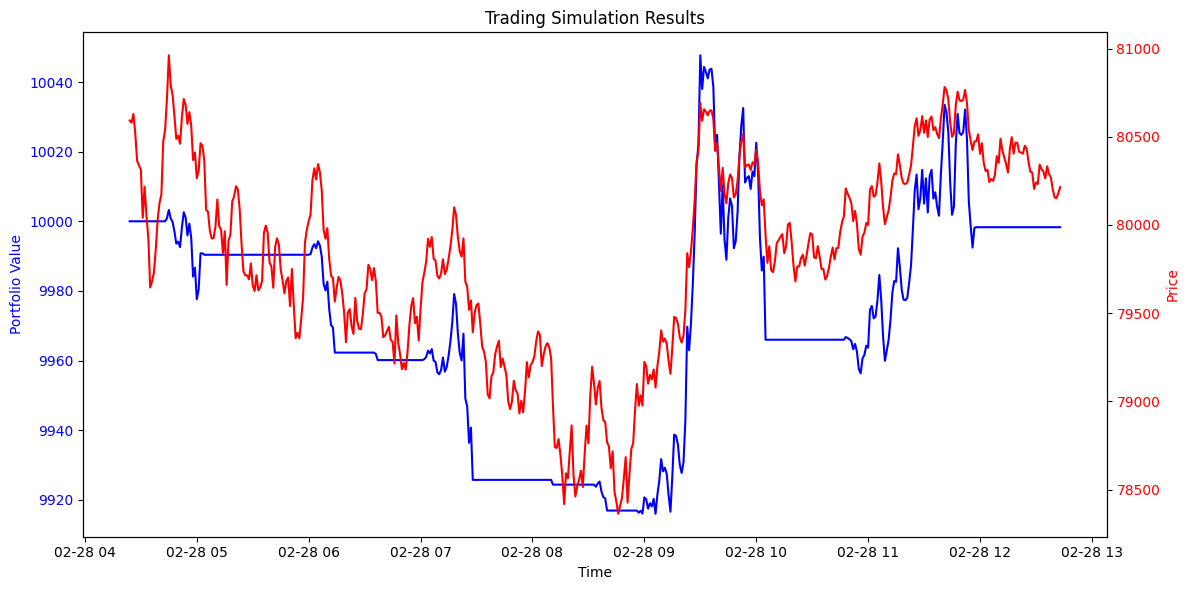

In [ ]:
# First, import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Load your data
data = pd.read_csv("binance_data.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Create configuration
config = {
    'initial_capital': 10000,
    'position_size_percentage': 0.04,
    'max_drawdown_limit': 0.18,
    'base_grid_step': 0.01,
    'profit_take_threshold': 0.015,
    'max_open_positions': 10,
    'fee_rate': 0.001,
    'risk_management': {
        'dynamic_position_sizing': True,
        'trailing_stop_loss': True,
        'dynamic_take_profit': True,
        'volatility_adjustment': True,
        'max_risk_per_trade': 0.02,
        'position_scaling': True
    },
    'filters': {
        'volatility_filter': True,
        'trend_filter': True,
        'volume_filter': True,
        'support_resistance_filter': True
    },
    'timeframes': {
        'short': '1h',
        'medium': '4h',
        'long': '1d'
    }
}

# Define GridTradingSimulator class
class GridTradingSimulator:
    def __init__(self, config):
        self.config = config
        self.available_capital = config['initial_capital']
        self.btc_holding = 0
        self.peak_value = self.available_capital
        self.trades = []

    def execute_trades(self, current_price, timestamp, trend_data, vol_data):
        """Simple trade execution logic (to be expanded)."""
        position_size = self.available_capital * self.config['position_size_percentage']
        if trend_data['trend'] == "up":
            self.btc_holding += position_size / current_price
            self.available_capital -= position_size
            self.trades.append({'timestamp': timestamp, 'price': current_price, 'type': 'buy'})
        elif trend_data['trend'] == "down" and self.btc_holding > 0:
            self.available_capital += self.btc_holding * current_price
            self.trades.append({'timestamp': timestamp, 'price': current_price, 'type': 'sell'})
            self.btc_holding = 0

    def simulate(self, data):
        """Simulate trading on historical data"""
        print("Starting simulation...")

        # Filter for last 3 years
        three_years_ago = datetime.now() - timedelta(days=3 * 365)
        data = data[data['timestamp'] >= three_years_ago].copy()

        # Initialize results tracking
        results = {
            'timestamp': [],
            'price': [],
            'portfolio_value': [],
            'drawdown': [],
            'btc_position': [],
            'volatility': [],
            'trend': []
        }

        # Run simulation
        for idx in range(len(data)):
            current_price = data['close'].iloc[idx]
            timestamp = data['timestamp'].iloc[idx]

            # Get market analysis
            price_window = data['close'].iloc[max(0, idx - 48):idx + 1]
            volume_window = data['volume'].iloc[max(0, idx - 48):idx + 1] if 'volume' in data.columns else None

            trend_data = detect_trend(price_window.values, volume_window.values if volume_window is not None else None)
            vol_data = calculate_volatility(price_window.values)

            # Execute trading logic
            self.execute_trades(current_price, timestamp, trend_data, vol_data)

            # Calculate portfolio value
            portfolio_value = self.available_capital + (self.btc_holding * current_price)

            # Update peak value and calculate drawdown
            self.peak_value = max(self.peak_value, portfolio_value)
            current_drawdown = (self.peak_value - portfolio_value) / self.peak_value

            # Store results
            results['timestamp'].append(timestamp)
            results['price'].append(current_price)
            results['portfolio_value'].append(portfolio_value)
            results['drawdown'].append(current_drawdown)
            results['btc_position'].append(self.btc_holding)
            results['volatility'].append(vol_data['volatility'])
            results['trend'].append(trend_data['trend'])

        # Create DataFrames
        results_df = pd.DataFrame(results)
        trades_df = pd.DataFrame(self.trades)

        return results_df, trades_df

    def visualize_trading_results(self, results_df, trades_df):
        """Plot the trading results"""
        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.set_xlabel("Time")
        ax1.set_ylabel("Portfolio Value", color="blue")
        ax1.plot(results_df['timestamp'], results_df['portfolio_value'], label="Portfolio Value", color="blue")
        ax1.tick_params(axis="y", labelcolor="blue")

        ax2 = ax1.twinx()
        ax2.set_ylabel("Price", color="red")
        ax2.plot(results_df['timestamp'], results_df['price'], label="BTC Price", color="red")
        ax2.tick_params(axis="y", labelcolor="red")

        plt.title("Trading Simulation Results")
        fig.tight_layout()
        plt.show()


# Define missing functions
def detect_trend(prices, volumes=None):
    """Detects simple trend based on moving average."""
    if len(prices) < 10:
        return {"trend": "neutral"}
    
    short_ma = np.mean(prices[-5:])
    long_ma = np.mean(prices)
    
    trend = "up" if short_ma > long_ma else "down" if short_ma < long_ma else "neutral"
    return {"trend": trend}


def calculate_volatility(prices):
    """Calculates simple volatility based on standard deviation."""
    if len(prices) < 10:
        return {"volatility": 0}
    
    return {"volatility": np.std(prices)}


# Create instance of GridTradingSimulator
simulator = GridTradingSimulator(config)

# Run the simulation
results_df, trades_df = simulator.simulate(data)

# Visualize results
simulator.visualize_trading_results(results_df, trades_df)


Starting simulation...
Final Portfolio Value: $9993.50
Total Profit: $-6.50
Max Drawdown (MDD): 2.32%


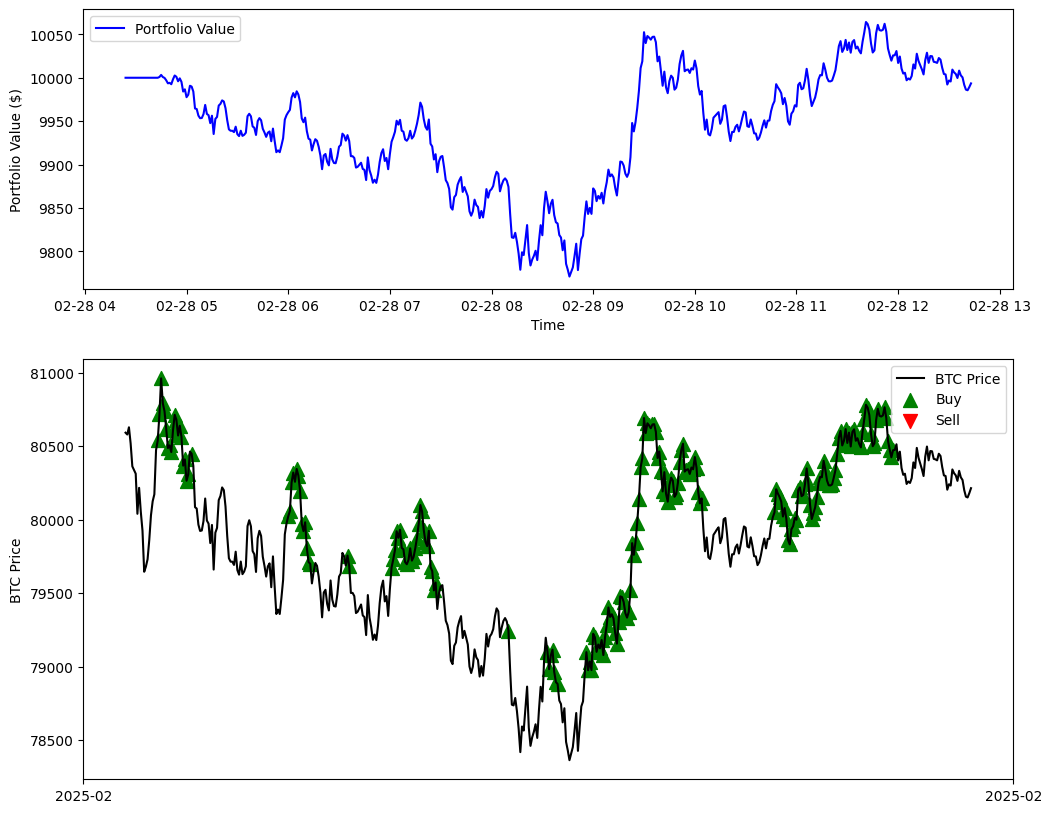

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import mplfinance as mpf  # Remove if still causing issues

# Load your data
data = pd.read_csv("binance_data.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Create configuration
config = {
    'initial_capital': 10000,
    'position_size_percentage': 0.04,
    'max_drawdown_limit': 0.18,
    'base_grid_step': 0.01,
    'profit_take_threshold': 0.02,  # Increased to maximize profits
    'stop_loss_threshold': 0.015,  # Added stop-loss
    'max_open_positions': 10,
    'fee_rate': 0.001,
}

# Define GridTradingSimulator class
class GridTradingSimulator:
    def __init__(self, config):
        self.config = config
        self.available_capital = config['initial_capital']
        self.btc_holding = 0
        self.peak_value = self.available_capital
        self.trades = []

    def execute_trades(self, current_price, timestamp, trend_data):
        """Trade execution with stop-loss & profit-taking."""
        position_size = self.available_capital * self.config['position_size_percentage']
        
        # Buy logic
        if trend_data['trend'] == "up" and self.available_capital >= position_size:
            self.btc_holding += position_size / current_price
            self.available_capital -= position_size
            self.trades.append({'timestamp': timestamp, 'price': current_price, 'type': 'buy'})

        # Sell logic with stop-loss & take-profit
        elif self.btc_holding > 0:
            entry_price = self.trades[-1]['price']
            profit_threshold = entry_price * (1 + self.config['profit_take_threshold'])
            stop_loss_threshold = entry_price * (1 - self.config['stop_loss_threshold'])

            if current_price >= profit_threshold or current_price <= stop_loss_threshold:
                self.available_capital += self.btc_holding * current_price
                self.trades.append({'timestamp': timestamp, 'price': current_price, 'type': 'sell'})
                self.btc_holding = 0

    def simulate(self, data):
        """Simulate trading on historical data"""
        print("Starting simulation...")

        # Filter for last 3 years
        three_years_ago = datetime.now() - timedelta(days=3 * 365)
        data = data[data['timestamp'] >= three_years_ago].copy()

        # Track results
        results = {'timestamp': [], 'price': [], 'portfolio_value': [], 'drawdown': []}
        max_drawdown = 0

        # Run simulation
        for idx in range(len(data)):
            current_price = data['close'].iloc[idx]
            timestamp = data['timestamp'].iloc[idx]

            # Trend analysis
            price_window = data['close'].iloc[max(0, idx - 48):idx + 1]
            trend_data = detect_trend(price_window.values)

            # Execute trading logic
            self.execute_trades(current_price, timestamp, trend_data)

            # Portfolio value
            portfolio_value = self.available_capital + (self.btc_holding * current_price)

            # Drawdown calculation
            self.peak_value = max(self.peak_value, portfolio_value)
            current_drawdown = (self.peak_value - portfolio_value) / self.peak_value
            max_drawdown = max(max_drawdown, current_drawdown)

            # Store results
            results['timestamp'].append(timestamp)
            results['price'].append(current_price)
            results['portfolio_value'].append(portfolio_value)
            results['drawdown'].append(current_drawdown)

        # Create DataFrames
        results_df = pd.DataFrame(results)
        trades_df = pd.DataFrame(self.trades)

        # Final calculations
        total_profit = portfolio_value - self.config['initial_capital']
        print(f"Final Portfolio Value: ${portfolio_value:.2f}")
        print(f"Total Profit: ${total_profit:.2f}")
        print(f"Max Drawdown (MDD): {max_drawdown:.2%}")

        return results_df, trades_df

    def visualize_trading_results(self, results_df, trades_df):
        """Visualize Portfolio and Price trends with Buy/Sell markers"""
        fig, axs = plt.subplots(2, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 3]})

        # **1. Portfolio Value**
        axs[0].plot(results_df['timestamp'], results_df['portfolio_value'], label="Portfolio Value", color="blue")
        axs[0].set_ylabel("Portfolio Value ($)")
        axs[0].set_xlabel("Time")
        axs[0].legend()

        # **2. Price & Trades**
        axs[1].plot(results_df['timestamp'], results_df['price'], label="BTC Price", color="black")

        # Add buy/sell markers
        buy_trades = trades_df[trades_df['type'] == 'buy']
        sell_trades = trades_df[trades_df['type'] == 'sell']

        axs[1].scatter(buy_trades['timestamp'], buy_trades['price'], color='green', marker='^', label="Buy", s=100)
        axs[1].scatter(sell_trades['timestamp'], sell_trades['price'], color='red', marker='v', label="Sell", s=100)

        axs[1].set_ylabel("BTC Price")
        axs[1].legend()
        axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

        plt.show()


# Trend Detection Function
def detect_trend(prices):
    """Simple moving average trend detection."""
    if len(prices) < 10:
        return {"trend": "neutral"}
    
    short_ma = np.mean(prices[-5:])
    long_ma = np.mean(prices)
    
    trend = "up" if short_ma > long_ma else "down" if short_ma < long_ma else "neutral"
    return {"trend": trend}


# Create instance of GridTradingSimulator
simulator = GridTradingSimulator(config)

# Run the simulation
results_df, trades_df = simulator.simulate(data)

# Visualize results
simulator.visualize_trading_results(results_df, trades_df)
